In [2]:
#Systems I/O
import os
from pathos.pools import ProcessPool
import glob
import mat73
from scipy.io import loadmat as lm
import re
import h5py

#data/stats
import numpy as np
from sklearn import svm

#viz
import seaborn as sns
import matplotlib.pyplot as plt

#specialty
from utils import *
from CrpStats import *

In [3]:
BANDS = ['delta', 'theta','alpha', 'beta', 'gamma_low','gamma_high']
DIR = '/mnt/ernie_main/000_Data/SEEG/SEEG_EyesClosed_RestingState/results/Graham_81pats/PDC_RestingState/'


In [4]:
pdc_f = os.path.join(DIR,"PDC_pats_6Band_pycomp.mat")
pdc_struct = lm(pdc_f, chars_as_strings=True)
pats = pdc_struct['pats']

## Notes on Matlab struct 
- Load struct and use 'pats' key to pull out 1x81 structs wrapped in tuple
- pull struct out of tuple for 81 structs with 7 fields per struct
- Index 0 again to get the row of 7 structs
- 




In [5]:
'''
Index to selects col in struct
                          |
Index to select patients  |
                       |  |  
                       |  |  
                       |  |  
epat_26_alpha = tst[0][0][2][0][0][2]
Columns in Struct
0 - subID
1 - labels
2 - "long" -> 6 x N x N PDC matrix (N= number of bipoles)
3 - pat_ID_clean - NOTE: use this one instead of labels! 
4 - SOZ, labels for each bipole -> 0 NIZ, 1 SOZ, 2 PZ, 3 NIZ
5 - AVG_SOZ  - ??
6 - long_Z - ?
'''

'\nIndex to selects col in struct\n                          |\nIndex to select patients  |\n                       |  |  \n                       |  |  \n                       |  |  \nepat_26_alpha = tst[0][0][2][0][0][2]\nColumns in Struct\n0 - subID\n1 - labels\n2 - "long" -> 6 x N x N PDC matrix (N= number of bipoles)\n3 - pat_ID_clean - NOTE: use this one instead of labels! \n4 - SOZ, labels for each bipole -> 0 NIZ, 1 SOZ, 2 PZ, 3 NIZ\n5 - AVG_SOZ  - ??\n6 - long_Z - ?\n'

In [6]:
pat_dict = dict()
h5f = os.path.join(DIR, 'PDC_pats_6Band.hdf5')
for i, subj_struct in enumerate(pats[0]):
    subj_id = subj_struct[3][0]
    soz_labels = format_soz(subj_struct[4])
    bip_labels = format_bipoles(subj_struct[1])
    pdc_mats = load_pdc(subj_struct[2])
    save_pdc_to_h5(h5f, subj_id, soz_labels, bip_labels,pdc_mats)


In [7]:
def load_pdc_h5(h5f):
    pdc_dict = defaultdict(lambda: dict())
    with h5py.File( h5f, 'r') as f:
        for k in f.keys():
            pat = f[k]
            labels_soz = pat['tissue_label']
            pdc_dict[k]['labels_soz'] = [ l.decode() for l in labels_soz[()]]
            bipole = pat['bipole_labels']
            pdc_dict[k]['bipole_labels'] = [bip.decode() for bip in bipole[()]]
       
            pdc_dict[k]['pdc'] = {band:v[()]for band, v in pat['pdc'].items()}
        return pdc_dict
adj_dicts = load_pdc_h5(h5f)


In [8]:
adj_dicts['Spat46']['pdc']

{'alpha': array([[       nan, 0.08121775, 0.0419141 , ..., 0.02757294, 0.0127103 ,
         0.02362049],
        [0.31402523,        nan, 0.14849229, ..., 0.02355176, 0.02071194,
         0.01919556],
        [0.13611629, 0.18367411,        nan, ..., 0.03895171, 0.02042827,
         0.03889821],
        ...,
        [0.0235339 , 0.01576947, 0.01412634, ...,        nan, 0.65840044,
         0.16857772],
        [0.02170797, 0.01619505, 0.01357687, ..., 0.32668203,        nan,
         0.27478232],
        [0.02955   , 0.01942208, 0.01558826, ..., 0.2817237 , 0.82951735,
                nan]]),
 'beta': array([[       nan, 0.14682119, 0.02225201, ..., 0.01783484, 0.00804556,
         0.01274602],
        [0.31681712,        nan, 0.15778989, ..., 0.01471994, 0.01374899,
         0.01627823],
        [0.13377487, 0.26485376,        nan, ..., 0.02522372, 0.01417333,
         0.02442025],
        ...,
        [0.01488578, 0.01131484, 0.00877774, ...,        nan, 0.59365538,
         0.149436

In [31]:
def construct_subj_df(adj_dicts:dict(), norm_style='bidirectional', band='alpha')->pd.DataFrame:
    """Takes a dictionary of partial directed coherencies and assembles a flattened
    dataframe where each row is a SUBJ, node values (avg-in/outdegree) after normalization, contact label

    Args:
        pdc_dicts (dict): _description_
        norm_style (str, optional): how to norm the adjacency matrix. Defaults to 'bidirectional'.

    Returns:
        pd.DataFrame: _description_
    """
    conn_dfs = []
    for subj, vals in adj_dicts.items():
        bipoles = vals['bipole_labels']
        mat = vals['pdc'][band]
        df = get_scored_df(mat,bipoles,norm_style)
        df['subj'] = subj
        df['label'] = vals['labels_soz']
        conn_dfs.append(df)
    return pd.concat(conn_dfs)

def get_scored_df(adj_mat, node_labels, norm_style='bidirectional'):
    df = pd.DataFrame()
    df['node_labels'] = node_labels
    if norm_style == 'bidirectional':
        outward_norm = score_adj_matrix(adj_mat, by='row')
        df['in_weight'] = np.nanmean(outward_norm, 0)
        inward_norm = score_adj_matrix(adj_mat, by='col')
        df['out_weight'] = np.nanmean(inward_norm, 1)
        #TODO: double check
    if norm_style == 'none':
        df['in_weight'] = np.nanmean(adj_mat, 0)
        df['out_weight'] = np.nanmean(adj_mat, 1)
    if  norm_style == 'whole_mat':
        mu = np.nanmean(adj_mat)
        std = np.nanstd(adj_mat)
        z_mat = np.divide(adj_mat-mu, std)
        df['in_weight'] = np.nanmean(z_mat, 0)
        df['out_weight'] = np.nanmean(z_mat, 1)

    return df

def adj_to_edgedf(adj_mat:np.array, labels: list[str], label_col, entry_col, sep_char)-> pd.DataFrame:
    edge_arr = adj_mat.flatten()
    label_arr = label_to_edge(labels, sep_char)
    return  pd.DataFrame(data={entry_col:edge_arr, label_col:label_arr})

def label_to_edge(labels, sep_char='-'):
    label_arr= np.char.array(labels) + sep_char
    label_mat = label_arr[:,None] + label_arr
    return list(map(lambda x: x.strip(sep_char), label_mat.flatten()))
pdc_df = construct_subj_df(adj_dicts, norm_style='whole_mat')


In [37]:
def construct_subj_edge_df(adj_dicts:dict(),  band='alpha'):
    conn_dfs = []
    for subj, vals in adj_dicts.items():
        bipoles = vals['bipole_labels']
        mat = vals['pdc'][band]
        df = adj_to_edgedf(mat,bipoles,'stim_resp', 'pdc_alpha', '_')
        df['subj'] = subj
        df['label'] = label_to_edge( vals['labels_soz'])
        conn_dfs.append(df)
    return pd.concat(conn_dfs)
edge_df = construct_subj_edge_df(adj_dicts)
edge_df 

,pdc_alpha,stim_resp,subj,label
0,NaN,LAC1-LAC2_LAC1-LAC2,Epat02,IZ-IZ
1,0.237952,LAC1-LAC2_LAC2-LAC3,Epat02,IZ-IZ
2,0.082986,LAC1-LAC2_LAC3-LAC4,Epat02,IZ-IZ
3,0.047647,LAC1-LAC2_LAC4-LAC5,Epat02,IZ-IZ
4,0.079708,LAC1-LAC2_LAC5-LAC6,Epat02,IZ-NIZ
...,...,...,...,...
5771,0.020887,LTP9-LTP10_LTP1-LTP2,pat33,NIZ-NIZ
5772,0.031324,LTP9-LTP10_LTP3-LTP4,pat33,NIZ-NIZ
5773,0.040203,LTP9-LTP10_LTP7-LTP8,pat33,NIZ-NIZ
5774,0.236732,LTP9-LTP10_LTP8-LTP9,pat33,NIZ-NIZ


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='in_weight'>

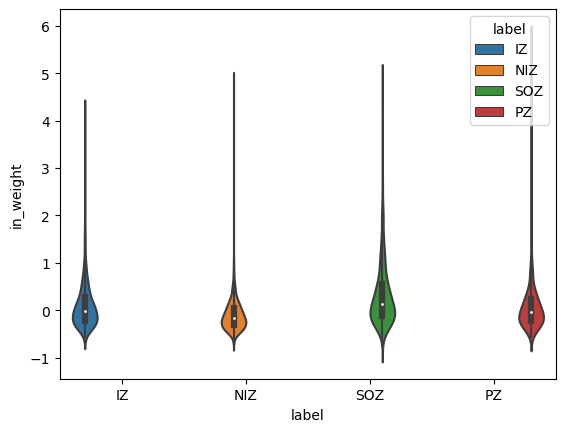

In [39]:
sns.violinplot(pdc_df, x='label',y='in_weight',hue='label')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='Count'>

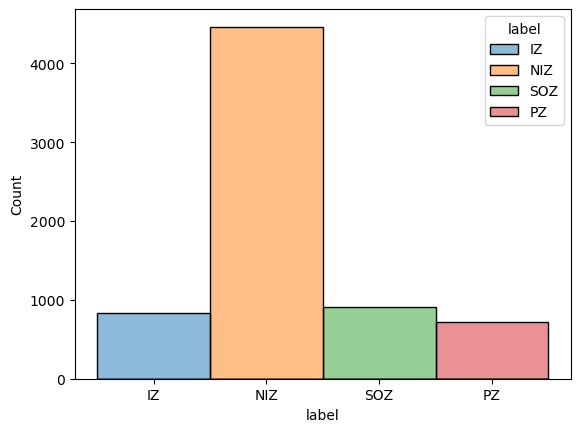

In [40]:
sns.histplot(pdc_df, x='label',hue='label')

In [41]:
set(pdc_df.subj)

{'Epat02',
 'Epat03',
 'Epat04',
 'Epat05',
 'Epat06',
 'Epat08',
 'Epat09',
 'Epat10',
 'Epat11',
 'Epat13',
 'Epat14',
 'Epat15',
 'Epat17',
 'Epat18',
 'Epat19',
 'Epat20',
 'Epat21',
 'Epat22',
 'Epat23',
 'Epat24',
 'Epat25',
 'Epat26',
 'Epat27',
 'Epat28',
 'Epat30',
 'Epat31',
 'Epat33',
 'Epat34',
 'Epat35',
 'Epat37',
 'Epat38',
 'Epat39',
 'Epat41',
 'Epat43',
 'Spat02',
 'Spat03',
 'Spat05',
 'Spat06',
 'Spat07',
 'Spat08',
 'Spat09',
 'Spat10',
 'Spat11',
 'Spat12',
 'Spat13',
 'Spat14',
 'Spat17',
 'Spat18',
 'Spat19',
 'Spat20',
 'Spat22',
 'Spat23',
 'Spat24',
 'Spat25',
 'Spat26',
 'Spat27',
 'Spat28',
 'Spat29',
 'Spat30',
 'Spat31',
 'Spat32',
 'Spat33',
 'Spat34',
 'Spat36',
 'Spat37',
 'Spat39',
 'Spat40',
 'Spat41',
 'Spat42',
 'Spat44',
 'Spat45',
 'Spat46',
 'Spat47',
 'Spat48',
 'Spat49',
 'Spat50',
 'Spat51',
 'Spat52',
 'Spat53',
 'pat11',
 'pat33'}

In [42]:
pdc_dicts['Epat06']['pdc']['alpha'][7,3]

NameError: name 'pdc_dicts' is not defined

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='in_weight'>

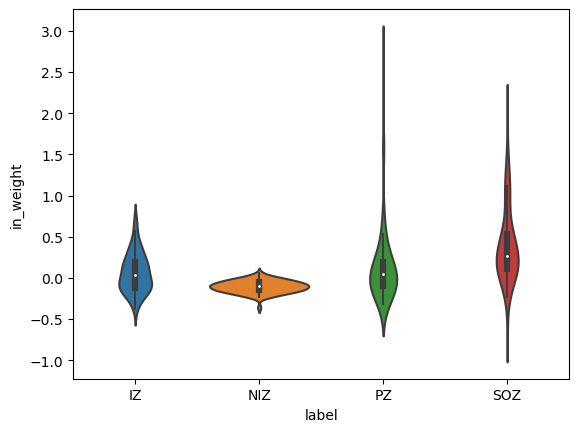

In [43]:
tmp_df =pdc_df[['in_weight','label','subj']].groupby(by=['label','subj']).mean().reset_index()
sns.violinplot(tmp_df, x='label',y='in_weight')

## TODO

Average within group
Lump iritative zone to NIZ
should have 3 violin plot 

In [44]:
out_dir = "/mnt/ernie_main/Ghassan/ephys/data/"
spes_df = pd.read_csv(os.path.join(out_dir, "crp_trials.csv"))


In [45]:
spes_df['stim_reg'] = spes_df.stim_sesh.apply(lambda x: "-".join(x.split("-")[0:2]))
spes_df['resp_reg'] = spes_df.stim_sesh.apply(lambda x: "-".join(x.split("-")[2:]))
spes_df['stim_label'] = spes_df.stim_rel.apply(lambda x : x.split('-')[0])
spes_df['resp_label'] = spes_df.stim_rel.apply(lambda x : x.split('-')[1])

In [46]:
def edgedf_to_adj(edge_df:pd.DataFrame, start_node:str, end_node:str, val_col:str)->list:
    edge_df = edge_df.sort_values(by =[start_node])
    node_list = list(set(edge_df[start_node]).union(set(edge_df[end_node])))
    node_list.sort()
    n = len(node_list)
    adj_mat = np.zeros((n,n))
    for index, edge in edge_df.iterrows():
        edge_val = edge[val_col]
        node_i = edge[start_node]
        node_j = edge[end_node] 
        i = node_list.index(node_i)
        j = node_list.index(node_j)
        adj_mat[i,j] = edge_val
    adj_mat[adj_mat ==0] = np.nan
    return node_list, adj_mat
tst = spes_df[spes_df.subj=='Epat26']

spes_dicts = defaultdict(lambda:dict())
for subj in set( spes_df.subj):
    bip_labels, ev_mat = edgedf_to_adj(spes_df[spes_df.subj==subj], 'stim_reg','resp_reg','explained_variance')
    spes_dicts[subj]['bipole_labels'] = bip_labels
    spes_dicts[subj]['ev_matrix'] = ev_mat



In [47]:
def construct_spes_df(adj_dicts:dict(),  mat_key, norm_style='bidirectional')->pd.DataFrame:
    """Takes a dictionary of any adjaceny matrix dictionary  and assembles a flattened
    dataframe where each row is a SUBJ, node values (avg-in/outdegree) after normalization, contact label

    Args:
        adj_dicts (dict): _description_
        norm_style (str, optional): how to norm the adjacency matrix. Defaults to 'bidirectional'.

    Returns:
        pd.DataFrame: _description_
    """
    conn_dfs = []
    for subj, vals in adj_dicts.items():
        bipoles = vals['bipole_labels']
        mat = vals[mat_key]
        df = get_scored_df(mat,bipoles,norm_style)
        df['subj'] = subj
        conn_dfs.append(df)
    return pd.concat(conn_dfs)

In [48]:
spes_node_df.columns

NameError: name 'spes_node_df' is not defined

In [49]:
spes_node_df = construct_spes_df(spes_dicts,'ev_matrix')
spes_node_df = spes_node_df.rename(columns={'in_weight':'in_ev','out_weight':'out_ev'},)

/home/ghassan/Ephys/Code/CRP/CrpStats.py:89: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(adj_mat, axis=dim)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_769594/577648257.py:40: RuntimeWarning: Mean of empty slice
  df['out_weight'] = np.nanmean(inward_norm, 1)
/home/ghassan/Ephys/Code/CRP/CrpStats.py:89: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(adj_mat, axis=dim)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_769594/577648257.py:40: RuntimeWarning: Mean of empty slice
  df['out_weight'] = np.nanmean(inward_norm, 1)
/home/ghassan/Ephys/Code/CRP/CrpStats.py:89: RuntimeWarning: Mean of empty slice
  mu = np.nanmean

In [50]:
spes_data_df = pdc_df.merge(spes_node_df, on=['node_labels','subj'])

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='in_weight'>

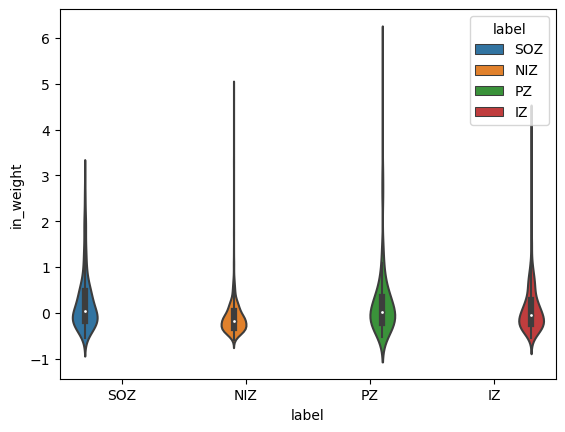

In [51]:
sns.violinplot(data=spes_data_df, x='label',y='in_weight', hue='label')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='out_weight'>

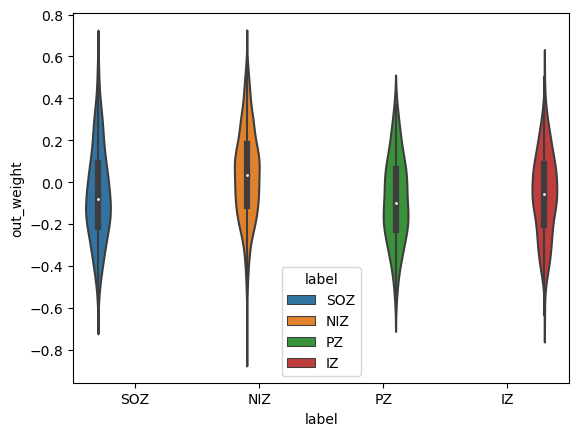

In [52]:
sns.violinplot(data=spes_data_df, x='label',y='out_weight', hue='label')

In [53]:
spes_data_df.label = spes_data_df.label.apply(lambda x: 'SOZ' if x == 'SOZ' or x == 'PZ' else 'Non-SOZ')
spes_data_df['bin_label'] = spes_data_df.label.apply(lambda x: 1 if x == "SOZ" or x=='PZ' else 0)

In [58]:
edge_df

,pdc_alpha,stim_resp,subj,label
1,0.056504,LTP1-LTP2_LTP2-LTP3,Epat26,SOZ-SOZ
2,0.030527,LTP1-LTP2_LTP4-LTP5,Epat26,SOZ-NIZ
3,0.017061,LTP1-LTP2_LTP5-LTP6,Epat26,SOZ-NIZ
4,0.022808,LTP1-LTP2_LTP6-LTP7,Epat26,SOZ-NIZ
5,0.025382,LTP1-LTP2_LTP7-LTP8,Epat26,SOZ-NIZ
...,...,...,...,...
7219,0.165394,TPE7-TPE8_TPE2-TPE3,Spat53,NIZ-NIZ
7220,0.158432,TPE7-TPE8_TPE3-TPE4,Spat53,NIZ-NIZ
7221,0.049486,TPE7-TPE8_TPE4-TPE5,Spat53,NIZ-NIZ
7222,0.105653,TPE7-TPE8_TPE5-TPE6,Spat53,NIZ-NIZ


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='pdc_alpha'>

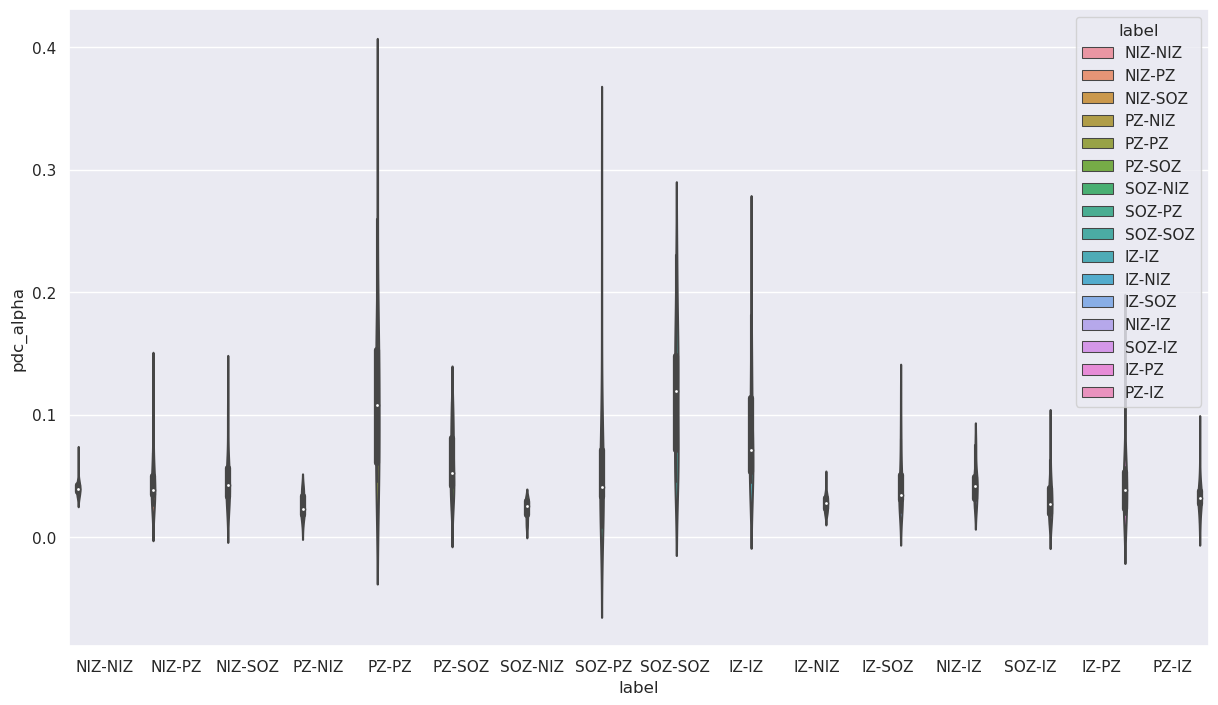

In [62]:
edge_df = edge_df[edge_df.subj.isin(set(spes_data_df.subj))]
edge_df = edge_df.dropna()
sns.set(rc={'figure.figsize':(14.7,8.27)})

grp_df = edge_df[['pdc_alpha', 'subj','label']].groupby(by=['subj','label']).mean().reset_index()
sns.violinplot(data=grp_df, x= 'label', y='pdc_alpha',hue='label')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='label', ylabel='Count'>

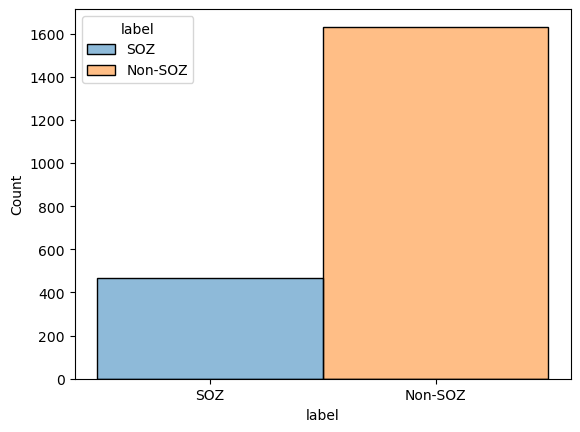

In [321]:
sns.histplot(spes_data_df, x='label', hue='label')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='in_ev', ylabel='Count'>

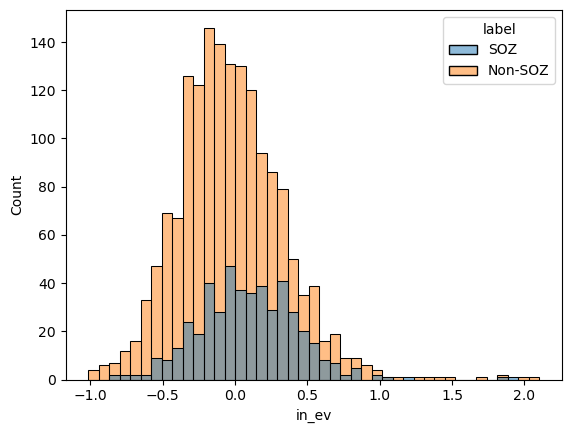

In [322]:
sns.histplot(data=spes_data_df, x='in_ev', hue='label')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

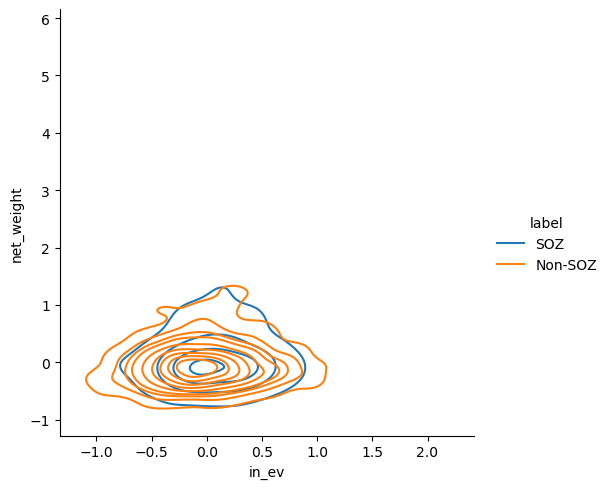

In [323]:
spes_data_df['net_weight'] = spes_data_df.in_weight + spes_data_df.out_weight
sns.displot(data=spes_data_df, x='in_ev', y='net_weight', hue='label',kind='kde')

# SVM Data Modeling

In [324]:
subj_set = set(spes_data_df.subj)
subj_arr = np.array(list(subj_set))
train_subj = subj_arr[np.random.randint(0, len(subj_set), size=(17))]
test_subj = np.array(list(subj_set.difference(train_subj)))

train_df = spes_data_df[spes_data_df.subj.isin(train_subj)]
X_train = train_df[['in_weight','out_weight','in_ev']].values
y_train = train_df.bin_label.values

test_df = spes_data_df[spes_data_df.subj.isin(test_subj)]
X_test = test_df[['in_weight', 'out_weight', 'in_ev']].values
y_test = test_df.bin_label.values

## CV and parameter sweep

Gamma is the kernel coefficient and likely the most important parameter to optimize across.

Default gamma = 1/(n_features *X.var())
             = 1/(3 * .17) ~= 1.96
Let's sweep over 3*X.var()

In [325]:
d = min(X_train.shape)
gammas = np.linspace( 1/(d* (X_train.var()/3)), 1/(d *X_train.var()*9) , 100)

In [332]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score, RocCurveDisplay
logo = LeaveOneGroupOut()
n_g, n_w = 100,10
n_splits = logo.get_n_splits(X_train, y_train, train_df.subj)

gamma_acc = np.zeros((n_g,n_w))
gamma_roc = np.zeros((n_g, n_w))
class_weights = np.linspace(1, 10, n_w)
for i,g in enumerate(gammas):
    for j, w in enumerate(class_weights):
        acc = np.array([])
        roc = np.array([])
        for _, (train_inds, val_inds) in enumerate(logo.split(X_train, y_train, train_df.subj)):
            X,y = X_train[train_inds,:], y_train[train_inds]
            X_val, y_val = X_train[val_inds,:], y_train[val_inds]
            svm = SVC(gamma=g, class_weight={1: w,0:1}, probability=True)
            svm.fit(X,y)
            y_pred = svm.predict(X_val)
            run_acc = y_pred == y_val
            run_roc =  roc_auc_score(y_val, svm.predict_proba(X_val)[:,1])
            acc =np.append(acc, run_acc)
            roc = np.append(roc, run_roc)
        cv_acc =np.sum(acc)/np.max(acc.shape)
        cv_roc = np.mean(roc)
        gamma_acc[i,j] = cv_acc
        gamma_roc[i,j] = cv_roc


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

In [242]:
gammas[::-1]

array([0.20940624, 0.26440182, 0.3193974 , 0.37439298, 0.42938856,
       0.48438414, 0.53937972, 0.5943753 , 0.64937088, 0.70436646,
       0.75936204, 0.81435762, 0.8693532 , 0.92434878, 0.97934436,
       1.03433994, 1.08933551, 1.14433109, 1.19932667, 1.25432225,
       1.30931783, 1.36431341, 1.41930899, 1.47430457, 1.52930015,
       1.58429573, 1.63929131, 1.69428689, 1.74928247, 1.80427805,
       1.85927363, 1.91426921, 1.96926479, 2.02426036, 2.07925594,
       2.13425152, 2.1892471 , 2.24424268, 2.29923826, 2.35423384,
       2.40922942, 2.464225  , 2.51922058, 2.57421616, 2.62921174,
       2.68420732, 2.7392029 , 2.79419848, 2.84919406, 2.90418964,
       2.95918521, 3.01418079, 3.06917637, 3.12417195, 3.17916753,
       3.23416311, 3.28915869, 3.34415427, 3.39914985, 3.45414543,
       3.50914101, 3.56413659, 3.61913217, 3.67412775, 3.72912333,
       3.78411891, 3.83911448, 3.89411006, 3.94910564, 4.00410122,
       4.0590968 , 4.11409238, 4.16908796, 4.22408354, 4.27907

Text(0.5, 1.0, 'Hyperparam Sweep evaluation')

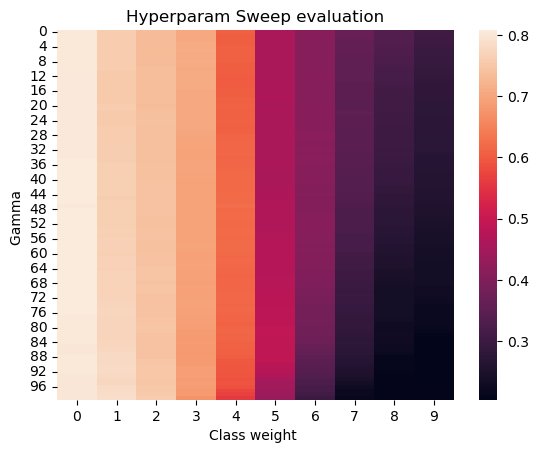

In [333]:

mat = np.matrix(gamma_acc)
mat.argmax(0)
mat.argmax(1)
sns.heatmap(mat)
plt.xlabel("Class weight ")
plt.ylabel("Gamma ")
plt.title(f"Hyperparam Sweep evaluation")

array([0.79938744, 0.78713629, 0.75650842, 0.67534456, 0.55819296,
       0.43415008, 0.29785605, 0.21592649, 0.20673813, 0.20444104])

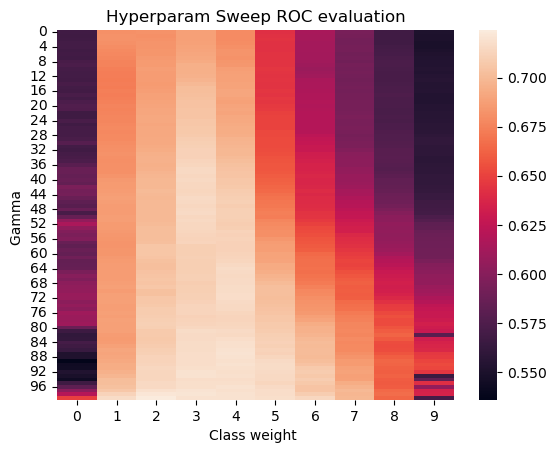

In [335]:

mat = np.matrix(gamma_acc)
mat.argmax(0)
mat.argmax(1)
sns.heatmap(gamma_roc)
plt.xlabel("Class weight ")
plt.ylabel("Gamma ")
plt.title(f"Hyperparam Sweep ROC evaluation")
gamma_acc[99,]

In [343]:
np.argmax(gamma_roc)
i,j = np.where( gamma_roc == np.max(gamma_roc))
print(f"Gamma val:{gammas[99]}, weights: {class_weights[j]}")

Gamma val:0.21338558305943264, weights: [3.]


In [346]:
c_max

array([3.])

In [350]:
g_max = gammas[i][0]
c_max = class_weights[j][0]

In [352]:
svm = SVC(probability=True, gamma=g_max, class_weight={1:c_max, 0:1})
svm.fit(X_train, y_train)
test_pred = svm.predict(X_test)
test_score = svm.predict_proba(X_test)
test_acc = test_pred == y_test



print(f'Test accuracy on SVM is {np.sum(test_acc)/len(test_acc)}')
print(f'ROC_auc_score : {roc_auc_score(y_test, test_score[:,1])}')

Test accuracy on SVM is 0.7257861635220125
ROC_auc_score : 0.6681456931527893


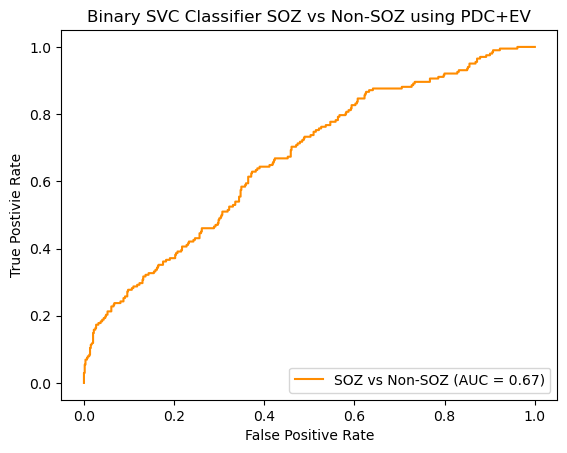

In [353]:
display = RocCurveDisplay.from_predictions(
    y_test, 
    test_score[:,1],
    name= "SOZ vs Non-SOZ",
    color = 'darkorange',
)
ax = display.ax_.set(
    xlabel = 'False Positive Rate',
    ylabel = 'True Postivie Rate',
    title = "Binary SVC Classifier SOZ vs Non-SOZ using PDC+EV"
)